<a href="https://colab.research.google.com/github/emacias-180/KONB/blob/main/EM_MJ2383_KONB_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**This notebook contains the code used for assignment Assignment 2 (KONB) of the course MJ2383 Energy System Economics, Modelling and Indicators for Sustainable Energy Development.**

The task at hand is to assess the evidence for the alternative energy projects:


*   Alternative 1 – A solar farm with large-scale battery storage
*   Alternative 2 – A gas-fired power plant (CCGT)

To do this, LCOE is used as the main indicator. Most of the LCOE-related functions used in this notebook are adapted from LAB 1. (https://github.com/KTH-dESA/MJ2383.git)

**Student name: Emilio Macías Amador**

Date: 15/09/2024

Parameters for solar PV farm with Battery Storage and combined cycle gas turbine (CCGT):

Parameter | Unit |PV + BESS | CCGT
---|---|---|---
Discount rate |% | 15 | 15
Overnight cost | €/kW | 2660 | 1024
Fixed O&M cost | €/kW	| 25 | 20
Variable O&M cost | €/kW	| 0 | 0.005
Lifetime| years |25|20
Efficiency |% | - |50
Load factor |%| 50-65 | 85
Fuel price | €/kWh| 0 | 0.01-0.05
Station capacity | MW |	800 | 500
Emission Factor	| tCO2e/kWh| 0 | 185




# Defining Key Functions

<a name="Stage-2---Explore-Parameter-Values"></a>
Defining the necessary functions to calculate LCOE and make plots with varying parameters, given the formula:

\\(LCOE = \frac{C_{fix} + \sum_{y=1}^Y DF_y \cdot C_y}{\sum_{y=1}^Y DF_y \cdot G_y}\\)

In [99]:
#import libraries
import numpy as np
import itertools
from plotly import express as px
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, fixed

In [100]:
def get_lcoe(capital_costs, operational_costs, electricity_generation, discount_rate, technical_lifetime):
    ''' Basic function to calculate LCOE in €/kWh

    Parameters
    ----------
    capital_costs : float, The capital cost of the technology €
    operational_costs : float, annual operational cost €
    electricity_generation : float, electricty generated per year KWh
    discount rate : float, yearly discount or interest rate
    technical_lifetime : int, number of years the technology can operate

    Returns
    -------
    float, The levelized cost of electricity in €/MWh
    '''
    years = np.arange(technical_lifetime)
    df = df = (1+discount_rate) ** - years
    lcoe = (1000*(capital_costs + sum(df * operational_costs)) / sum(df * electricity_generation))
    return lcoe

In [101]:
def get_lcoe_inputs(station_size, overnight_cost, fuel_efficiency, technical_lifetime,
                   fuel_price, fixed_om_cost, load_factor, variable_om_cost,emission_factor,carbon_tax):
    """Calculates the inputs needed for the lcoe function
      - Capital cost
      - Fixed and variable O&M costs
      - Annual electricity generation
      - Annual operational cost

    Parameters
    ----------
    station_size : float, The capacity of the technology in kW
    overnight_cost : float, The capital cost of the technology in €/kW
    fuel_efficiency : float, The ratio describing quantity of fuel required per unit of activity
    fuel_price : float, The price paid per unit of input fuel in €/kWh
    fixed_om_cost : float, The fixed operation and maintenance cost of the technology in €/kW
    load_factor : float, The percentage of the year in which the technology generates electricity in %.
    variable_om_cost : float, The variable operation and maintenance cost of the technology in €/kW
    technical_lifetime : int, The number of years the technology can operate
    emission_factor: float, The carbon intensity of the technology in tCO2e/kWh
    carbon_tax: float, The carbon tax of the technology in €/tCO2e

    Returns
    -------
    dict, A dictionary containing:
            capital_cost : float, The capital cost of the technology €
            total_fixed_om_cost : float, Fixed costs €
            annual_electricity_generation : np.ndarray, annual electricity production kWh
            total_variable_om_cost : float, variable cost due to fuel use €
            annual_operational_cost : np.ndarray, annual operational cost €
    """
    HOURS_IN_YEAR = 8760
    capital_cost = station_size * overnight_cost
    total_fixed_om_cost = station_size * fixed_om_cost
    annual_electricity_generation = np.repeat(station_size * HOURS_IN_YEAR * load_factor, technical_lifetime)

    total_variable_om_cost = ((annual_electricity_generation / fuel_efficiency) * (fuel_price)/1000) + \
                             (annual_electricity_generation * variable_om_cost) + \
                             (annual_electricity_generation * emission_factor * carbon_tax)

    annual_operational_cost = total_fixed_om_cost + total_variable_om_cost

    return {'capital_cost': capital_cost, 'total_fixed_om_cost': total_fixed_om_cost,
            'annual_electricity_generation': annual_electricity_generation,
            'total_variable_om_cost': total_variable_om_cost, 'annual_operational_cost': annual_operational_cost}

In [102]:
def extended_lcoe(station_size, overnight_cost, fuel_efficiency, fuel_price, fixed_om_cost, var_om_cost,
                  load_factor, discount_rate, technical_lifetime,em_factor,CO2_tax):
    """Calculates levelized cost of electricity,
     using the basic calculation from get_lcoe and the inputs from get_lcoe_inputs

    Parameters
    ----------
    station_size : float, The capacity of the technology in kW
    overnight_cost : float, The capital cost of the technology in €/kW
    fuel_efficiency : float, The ratio describing quantity of fuel required per unit of activity
    fuel_price : float, The price paid per unit of input fuel in €/kWh
    fixed_om_cost : float, The fixed operation and maintenance cost of the technology in €/kW
    load_factor : float, The percentage of the year in which the technology generates electricity in %.
    variable_om_cost : float, The variable operation and maintenance cost of the technology in €/kW
    technical_lifetime : int, The number of years the technology can operate
    *discount_rate : float, A decimal value less than 1*

    Returns
    -------
    float, The levelized cost of electricity in €/kWh
    """
    lcoe_params = get_lcoe_inputs(station_size, overnight_cost, fuel_efficiency, technical_lifetime,
                                 fuel_price, fixed_om_cost, load_factor, var_om_cost,em_factor,CO2_tax)

    value = get_lcoe(lcoe_params['capital_cost'], lcoe_params['annual_operational_cost'],
                     lcoe_params['annual_electricity_generation'], discount_rate,
                     technical_lifetime)
    return value

In [103]:
def calculate_ccgt(station_size, overnight_cost, fixed_om_cost, load_factor, efficiency,
                         fuel_prices, discount_rate, technical_lifetime, technology, var_om_cost,em_factor,CO2_tax):
    """Calculate LCOE for cartesian product of all parameter lists
    """
    results = []  # Create a list to hold the observations

    # Loop over cartesian product of parameter values
    for fuel_price in fuel_prices:

        observation = {}  # Create a dictionary to store the observation
        params = get_lcoe_inputs(station_size, overnight_cost, efficiency, technical_lifetime,
                                fuel_price, fixed_om_cost, load_factor, var_om_cost,em_factor,CO2_tax)
        lcoe = extended_lcoe(station_size, overnight_cost, efficiency, fuel_price, fixed_om_cost, var_om_cost,
                             load_factor, discount_rate, technical_lifetime,em_factor,CO2_tax)

        observation['Technology'] = technology
        observation['StationSize'] = station_size
        observation['OvernightCost'] = overnight_cost
        observation['FixedOMCost'] = fixed_om_cost
        observation['LoadFactor'] = load_factor
        observation['Efficiency'] = efficiency
        observation['FuelPrice'] = fuel_price
        observation['DiscountRate'] = discount_rate
        observation['Lifetime'] = technical_lifetime
        observation['LCOE'] = lcoe

        year = np.arange(technical_lifetime)
        df = (1 + discount_rate) ** - year

        observation['Fixed OM Cost'] = sum(df * params['total_fixed_om_cost']) / \
                                       sum(df * params['annual_electricity_generation'])
        observation['Variable OM Cost'] = sum(df * params['total_variable_om_cost']) / \
                                          sum(df * params['annual_electricity_generation'])
        observation['Capital Cost'] = params['capital_cost'] / \
                                      sum(df * params['annual_electricity_generation'])
        results.append(observation)

    return results

In [104]:
def calculate_pv_bess(station_size, overnight_cost, fixed_om_cost, load_factors, efficiency,
                         fuel_price, discount_rate, technical_lifetime, technology, var_om_cost,em_factor,CO2_tax):
    """Calculate LCOE for cartesian product of all parameter lists
    """
    results = []  # Create a list to hold the observations

    # Loop over cartesian product of parameter values
    for load_factor in load_factors:

        observation = {}  # Create a dictionary to store the observation
        params = get_lcoe_inputs(station_size, overnight_cost, efficiency, technical_lifetime,
                                fuel_price, fixed_om_cost, load_factor, var_om_cost,em_factor,CO2_tax)
        lcoe = extended_lcoe(station_size, overnight_cost, efficiency, fuel_price, fixed_om_cost, var_om_cost,
                             load_factor, discount_rate, technical_lifetime,em_factor,CO2_tax)

        observation['Technology'] = technology
        observation['StationSize'] = station_size
        observation['OvernightCost'] = overnight_cost
        observation['FixedOMCost'] = fixed_om_cost
        observation['LoadFactor'] = load_factor
        observation['Efficiency'] = efficiency
        observation['FuelPrice'] = fuel_price
        observation['DiscountRate'] = discount_rate
        observation['Lifetime'] = technical_lifetime
        observation['LCOE'] = lcoe

        year = np.arange(technical_lifetime)
        df = (1 + discount_rate) ** - year

        observation['Fixed OM Cost'] = sum(df * params['total_fixed_om_cost']) / \
                                       sum(df * params['annual_electricity_generation'])
        observation['Variable OM Cost'] = sum(df * params['total_variable_om_cost']) / \
                                          sum(df * params['annual_electricity_generation'])
        observation['Capital Cost'] = params['capital_cost'] / \
                                      sum(df * params['annual_electricity_generation'])
        results.append(observation)

    return results

In [105]:
def get_emissions(technical_lifetime,station_size,fuel_efficiency,load_factor,emission_factor):
    annual_electricity_generation = station_size * 8760 * load_factor
    annual_emissions = annual_electricity_generation * emission_factor
    total_emissions = annual_emissions * technical_lifetime
    total_geneation = annual_electricity_generation * technical_lifetime
    return annual_electricity_generation,total_geneation,annual_emissions, total_emissions

<a name="Stage-3:-Comparing-technologies"></a>
# Comparing Technologies


In [106]:
#for CCGT *******************************************************************
# ranging factors:
#fuel price ranging from 10 to 50 with a step of 10 euros/MWh
fuel_prices = np.arange(10, 60, 10) #<--------------------------------

# universal parameters:
discount_rate = 0.15 # %
carbon_tax = 0 # €/tCO2e <--------------------------------------------

# CCGT plant parameters
technical_lifetime = 25 # years
station_size = 500e3  # kW
overnight_cost = 1024  # €/kW
fixed_om_cost = 20 # €/kW
var_om_cost = 0.005 # €/kW
fuel_efficiency = 0.5
load_factor = 0.85
emission_factor = 0.000185 #tCO2e/kWh.

ccgt_results = calculate_ccgt(
    station_size, overnight_cost, fixed_om_cost, load_factor, fuel_efficiency,
    fuel_prices, discount_rate, technical_lifetime, 'CCGT', var_om_cost,emission_factor,carbon_tax)

data_ccgt = pd.DataFrame(ccgt_results)
#print(data_ccgt.head(5))

#for PV+BESS *****************************************************************
# ranging factors:
#load factors ranging from 0.3 to 1 with steps of 0.01
load_factors = np.arange(0.4, 0.91, 0.01) #<-----------------------------

# universal parameters:
discount_rate = 0.15 # %

# PV plant parameters
technical_lifetime = 20 # years
station_size = 800e3 # kW
overnight_cost = 2660  # €/kW
fixed_om_cost = 25 # €/kW
var_om_cost = 0.0 # €/kW
fuel_efficiency = 1.0
fuel_price = 0.0 # €/kW
emission_factor = 0.0 # €/kW

pv_bess_results = calculate_pv_bess(
    station_size, overnight_cost, fixed_om_cost, load_factors, fuel_efficiency,
    fuel_price, discount_rate, technical_lifetime, 'PV+BESS', var_om_cost,emission_factor,carbon_tax)

data_pv = pd.DataFrame(pv_bess_results)
#print(data_pv.head(3))

# Assuming load_factors is supposed to be on the x-axis
#px.line(data_pv, x='LoadFactor', y='LCOE', title='LCOE vs Load Factor')
#px.line(data_ccgt, x=fuel_prices, y='LCOE', title='LCOE vs Fuel Price')

<a name="Stage-4:-Plotting"></a>
# Plots and Emissions Results

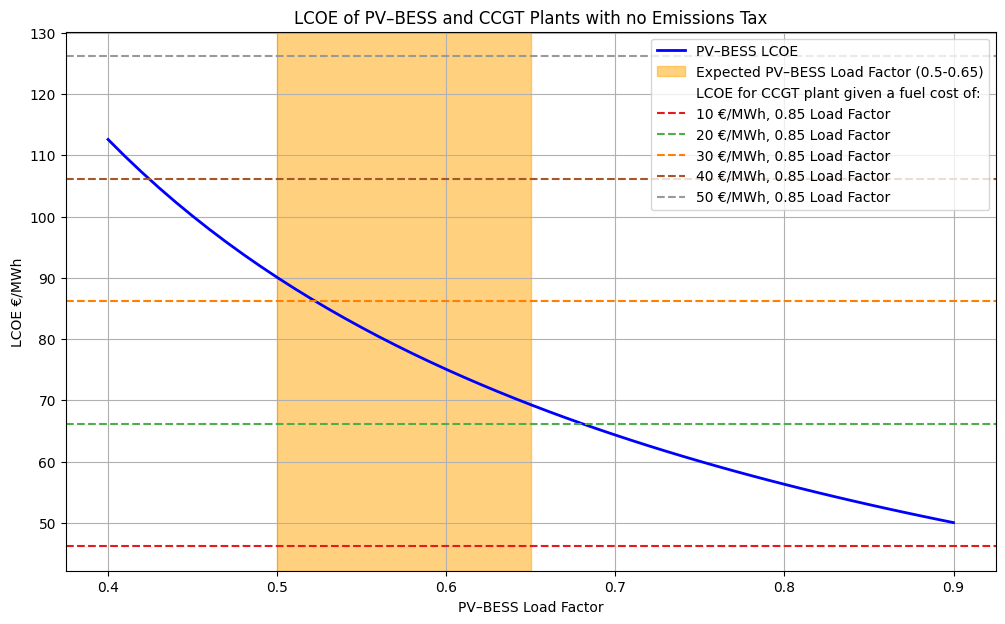

In [107]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#keep only LCOE colum from data_PV
data_pv = data_pv[['Technology','LCOE','LoadFactor','FuelPrice']]
#keep only LCOE colum from data_CCGT
data_ccgt = data_ccgt[['Technology','LCOE','LoadFactor','FuelPrice']]

# Assuming your data is in 'data_pv' and 'data_ccgt' as described

# Create a colormap with distinct colors
cmap = plt.get_cmap('Set1', len(data_ccgt))

# Create the plot
plt.figure(figsize=(12, 7))

# Plot the LCOE vs LoadFactor for data_pv
plt.plot(data_pv['LoadFactor'], data_pv['LCOE'], label='PV–BESS LCOE', color='blue', linewidth=2)

# Add a vertical yellow band from LoadFactor 0.5 to 0.65
plt.axvspan(0.5, 0.65, color='orange', alpha=0.5, label='Expected PV–BESS Load Factor (0.5-0.65)')

# Add horizontal lines for each LCOE value in data_ccgt (for each fuel price)
for i, row in data_ccgt.iterrows():
    plt.axhline(y=row['LCOE'], color=cmap(i), linestyle='--', label=f"{row['FuelPrice']} €/MWh, 0.85 Load Factor")

# Add labels and title
plt.xlabel('PV–BESS Load Factor')
plt.ylabel('LCOE €/MWh')
#plt.title('LCOE of PV–BESS and CCGT Plants with 100 €/tCO2e Tax')
plt.title('LCOE of PV–BESS and CCGT Plants with no Emissions Tax')

# Custom legend
handles, labels = plt.gca().get_legend_handles_labels()

# Create a custom legend with a subtitle for the gas power plant lines
# Insert the subtitle at the correct position (before the gas plant lines)
handles.insert(2, plt.Line2D([], [], color='none', label='LCOE values for gas power plant for different fuel costs'))
labels.insert(2, 'LCOE for CCGT plant given a fuel cost of:')

# Display the custom legend
plt.legend(handles=handles, labels=labels, loc='upper right')

# Show the plot
plt.grid(True)
plt.show()

In [108]:
#compute CO2 equivalent emissions for CCGT plant
technical_lifetime = 25 # years
station_size = 500e3  # kW
fuel_efficiency = 0.5
load_factor = 0.85
emission_factor = 0.000185 #tCO2e/kWh.

get_emissions(technical_lifetime,station_size,fuel_efficiency,load_factor,emission_factor)

print('Yearly')
print('----------------')
print(annual_electricity_generation/1e9,'TWh')
print(annual_emissions/1e3,'ktCO2e')
print('----------------')
print('Total')
print('----------------')
print(technical_lifetime*annual_electricity_generation/1e9,'TWh')
print(technical_lifetime*annual_emissions/1e6,'million tCO2e')
print('----------------')

Yearly
----------------
3.723 TWh
688.755 ktCO2e
----------------
Total
----------------
93.075 TWh
17.218875 million tCO2e
----------------
